In [1]:
import pandas as pd

## 1. Tiền xử lý dữ liệu

In [2]:
# Đọc từng file từ thư mục MXH_Dataset
train = pd.read_csv("../Dataset/train.csv")
segment_status = pd.read_csv("../Dataset/segment_status.csv")


In [3]:
# Kiểm tra số dòng, số cột của từng file
for name, df in [("segment_status", segment_status), 
                 ("train", train)]:
    print(f"{name}: {df.info}")

segment_status: <bound method DataFrame.info of          _id                updated_at  segment_id  velocity
0          0  2020-07-03T14:55:31.869Z       24845        20
1          1  2020-07-03T15:02:56.048Z       33923        10
2          2  2020-07-04T08:15:52.696Z       33824         5
3          3  2020-07-04T08:15:59.903Z       33824         5
4          4  2020-07-04T08:16:08.201Z       33824         5
...      ...                       ...         ...       ...
90933  90933  2021-04-22T06:52:39.280Z       52247         1
90934  90934  2021-04-22T06:52:52.501Z       52247         1
90935  90935  2021-04-22T06:53:02.335Z       52247         1
90936  90936  2021-04-22T06:53:14.294Z       52247         1
90937  90937  2021-04-22T06:53:27.300Z       52247         1

[90938 rows x 4 columns]>
train: <bound method DataFrame.info of          _id  segment_id        date  weekday        period LOS   s_node_id  \
0          0          26  2021-04-16        4   period_0_30   A   366428456

### 1.1 Merge file train và file segment_status

In [4]:
# Hàm convert period (vd: "period_14_30") thành timedelta
def period_to_time(period_str):
    try:
        _, hour_str, min_str = period_str.split("_")
        hour = int(hour_str)
        minute = int(min_str)
        return pd.to_timedelta(f"{hour}:{minute}:00")
    except:
        return pd.NaT

# Apply và tạo cột thời gian đầy đủ
train['time_delta'] = train['period'].apply(period_to_time)
train['date'] = pd.to_datetime(train['date']) + train['time_delta']

# Xoá cột phụ nếu muốn
train.drop(columns='time_delta', inplace=True)


In [5]:
# Chuyển 'date' và 'updated_at' về datetime
train['date'] = pd.to_datetime(train['date']).dt.tz_localize(None)
segment_status['updated_at'] = pd.to_datetime(segment_status['updated_at']).dt.tz_localize(None)

# Sort trước khi dùng merge_asof
train = train.sort_values(by='date')
segment_status = segment_status.sort_values(by='updated_at')

# Merge gần đúng theo thời gian, trong cùng segment_id
df = pd.merge_asof(
    train,
    segment_status,
    by='segment_id',
    left_on='date',
    right_on='updated_at',
    direction='nearest',  # hoặc 'backward' nếu bạn chỉ muốn dùng dữ liệu trước đó
    tolerance=pd.Timedelta('30min')  # chỉ chấp nhận khớp nếu lệch thời gian <= 30 phút
)

# Kiểm tra kết quả merge
print("\nMerged DataFrame:")
print(df.head())
# Kiểm tra các cột trong DataFrame sau khi merge
print("\nColumns in Merged DataFrame:")
print(df.columns)


Merged DataFrame:
   _id_x  segment_id                date  weekday        period LOS  \
0   9598       24845 2020-07-03 14:30:00        4  period_14_30   D   
1  13056       33923 2020-07-03 15:00:00        4  period_15_00   F   
2  12977       33824 2020-07-04 08:00:00        5   period_8_00   F   
3  12978       33824 2020-07-04 08:30:00        5   period_8_30   E   
4  23199       56816 2020-07-04 08:30:00        5   period_8_30   F   

    s_node_id   e_node_id  length  street_id  ...  street_level  \
0  2409410635  3771416347      73  138877181  ...             2   
1  5769406275  5769406276      78  213726584  ...             4   
2  2233730990  2299409160      67  213719139  ...             4   
3  2233730990  2299409160      67  213719139  ...             4   
4  5772558121  5772558074      89  398665528  ...             4   

     street_name  street_type  long_snode  lat_snode  long_enode  lat_enode  \
0   Trường Chinh      primary  106.651961  10.793623  106.652559  10.793

In [6]:
missing_segments = df[df['velocity'].isna()]['segment_id'].unique()
print("Các segment_id không có velocity sau khi merge:")
print(missing_segments)

# Check xem những segment_id đó có tồn tại bên segment_status không
segment_ids_in_status = segment_status['segment_id'].unique()
missing_but_exist = [seg for seg in missing_segments if seg in segment_ids_in_status]

print("\nNhững segment_id có trong segment_status nhưng vẫn bị NaN:")
print(missing_but_exist)

Các segment_id không có velocity sau khi merge:
[]

Những segment_id có trong segment_status nhưng vẫn bị NaN:
[]


### 1.2 Xử lý dữ liệu thiếu 

In [7]:
# Xóa các cột không cần thiết
drop_cols = ['_id_x', '_id_y', 's_node_id', 'e_node_id', 'street_id','segment_id', 'long_snode', 'lat_snode', 'long_enode', 'lat_enode', 'updated_at']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33441 entries, 0 to 33440
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          33441 non-null  datetime64[ns]
 1   weekday       33441 non-null  int64         
 2   period        33441 non-null  object        
 3   LOS           33441 non-null  object        
 4   length        33441 non-null  int64         
 5   max_velocity  4946 non-null   float64       
 6   street_level  33441 non-null  int64         
 7   street_name   33440 non-null  object        
 8   street_type   33441 non-null  object        
 9   velocity      33441 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 2.6+ MB


In [9]:
# Kiểm tra các giá trị thiếu trong dataframe
print(f"\nMissing values in dataframe:")
print(df.isnull().sum())


Missing values in dataframe:
date                0
weekday             0
period              0
LOS                 0
length              0
max_velocity    28495
street_level        0
street_name         1
street_type         0
velocity            0
dtype: int64


In [10]:
# Xử lý giá trị thiếu trong max_velocity
if df['max_velocity'].isnull().sum() > 0:
    df['max_velocity'] = df.groupby('street_type')['max_velocity'].transform(
        lambda x: x.fillna(x.mean())
    )
    df['max_velocity'] = df['max_velocity'].fillna(df['max_velocity'].mean())

# Gán 'Unknown' cho các giá trị thiếu của cột street, street_namename
df['street_name'] = df['street_name'].fillna('Unknown')

# Kiểm tra các giá trị thiếu trong dataframe
print(f"\nMissing values in dataframe:")
print(df.isnull().sum())


Missing values in dataframe:
date            0
weekday         0
period          0
LOS             0
length          0
max_velocity    0
street_level    0
street_name     0
street_type     0
velocity        0
dtype: int64


### 1.2 TÁCH TẬP TRAIN VÀ TEST

In [11]:
# Kiểm tra tên cột
print(df.columns)

Index(['date', 'weekday', 'period', 'LOS', 'length', 'max_velocity',
       'street_level', 'street_name', 'street_type', 'velocity'],
      dtype='object')


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Encode biến mục tiêu
label_encoder = LabelEncoder()
df['LOS_encoded'] = label_encoder.fit_transform(df['LOS'])

# Chia train/test theo tỉ lệ 80:20, KHÔNG shuffle để giữ thứ tự thời gian (nếu cần)
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# In kích thước tập train/test
print('Shape of train_data:', train_data.shape)
print('Shape of test_data:', test_data.shape)

# Tách biến mục tiêu
y_train = train_data['LOS_encoded']
y_test = test_data['LOS_encoded']

# Tách biến đầu vào
categorical_cols = ['weekday', 'period']
numerical_cols = ['max_velocity', 'length', 'velocity']
X_train_raw = train_data[categorical_cols + numerical_cols]
X_test_raw = test_data[categorical_cols + numerical_cols]

Shape of train_data: (26752, 11)
Shape of test_data: (6689, 11)


In [24]:
# Kiểm tra phân phối lớp LOS
print("\nPhân phối lớp LOS trong tập train:")
print(train_data['LOS'].value_counts())
print("\nPhân phối lớp LOS trong tập test:")
print(test_data['LOS'].value_counts())


Phân phối lớp LOS trong tập train:
LOS
A    10948
B     4117
E     3142
D     3062
C     3041
F     2442
Name: count, dtype: int64

Phân phối lớp LOS trong tập test:
LOS
A    2330
F    1647
C     798
E     686
D     645
B     583
Name: count, dtype: int64


### 1.3 CHUẨN HÓA DỮ LIỆU

In [13]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# 3. Scale numerical columns: fit trên train, transform cả hai
numerical_cols = ['max_velocity', 'length', 'velocity']
scaler = MinMaxScaler()
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

# 4. Xử lý categorical: one-hot encoding
categorical_cols = ['weekday', 'period']
X_train_raw = train_data[categorical_cols + numerical_cols]
X_test_raw = test_data[categorical_cols + numerical_cols]

encoder = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

X_train = encoder.fit_transform(X_train_raw)
X_test = encoder.transform(X_test_raw)

# 5. Lấy y
y_train = train_data['LOS_encoded']
y_test = test_data['LOS_encoded']

## 2. Thông tin chi tiết của tập Train và Test

In [14]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26752 entries, 0 to 26751
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          26752 non-null  datetime64[ns]
 1   weekday       26752 non-null  int64         
 2   period        26752 non-null  object        
 3   LOS           26752 non-null  object        
 4   length        26752 non-null  float64       
 5   max_velocity  26752 non-null  float64       
 6   street_level  26752 non-null  int64         
 7   street_name   26752 non-null  object        
 8   street_type   26752 non-null  object        
 9   velocity      26752 non-null  float64       
 10  LOS_encoded   26752 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 6689 entries, 26752 to 33440
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ---

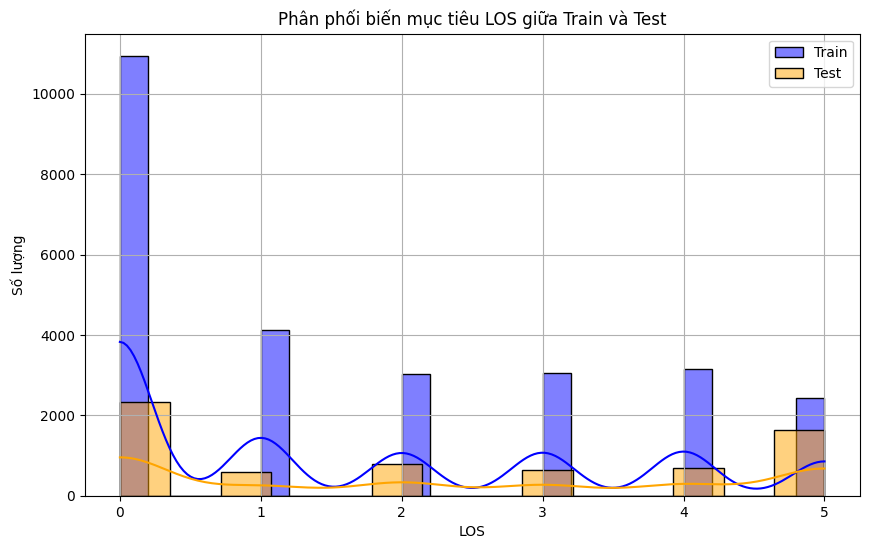

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(y_train, color='blue', label='Train', kde=True)
sns.histplot(y_test, color='orange', label='Test', kde=True)
plt.title('Phân phối biến mục tiêu LOS giữa Train và Test')
plt.xlabel('LOS')
plt.ylabel('Số lượng')
plt.legend()
plt.grid(True)
plt.show()


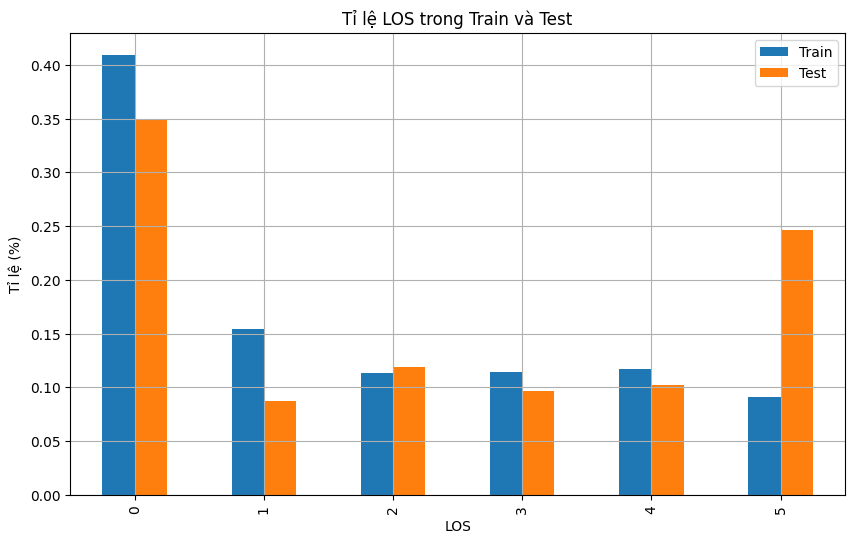

In [16]:
los_train_counts = y_train.value_counts(normalize=True)
los_test_counts = y_test.value_counts(normalize=True)

df_compare = pd.DataFrame({
    'Train': los_train_counts,
    'Test': los_test_counts
})

df_compare.plot(kind='bar', figsize=(10,6))
plt.title('Tỉ lệ LOS trong Train và Test')
plt.ylabel('Tỉ lệ (%)')
plt.xlabel('LOS')
plt.grid(True)
plt.show()


In [17]:
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer

# # Hàm scale_columns (giữ nguyên như bạn đã định nghĩa)
# def scale_columns(df, scaler, fit=True, cols=[]):
#     existing_cols = [col for col in cols if col in df.columns]
#     if fit:
#         df[existing_cols] = scaler.fit_transform(df[existing_cols])
#     else:
#         df[existing_cols] = scaler.transform(df[existing_cols])
#     return df


# # Danh sách cột cho từng DataFrame
# df_cols = ['max_velocity', 'length', 'velocity']    # train có cả hai cột

# # Train dùng cả 2 cột
# df_scaler = MinMaxScaler()
# df = scale_columns(df, df_scaler, fit=True, cols=df_cols)


In [18]:
# #one hot encode các cột categorical
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from sklearn.model_selection import train_test_split

# # Encode biến mục tiêu
# label_encoder = LabelEncoder()
# df['LOS_encoded'] = label_encoder.fit_transform(df['LOS'])

# # Chia train/test theo tỉ lệ 80:20, KHÔNG shuffle để giữ thứ tự thời gian (nếu cần)
# train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# # In kích thước tập train/test
# print('Shape of train_data:', train_data.shape)
# print('Shape of test_data:', test_data.shape)




# # Tách biến mục tiêu
# y_train = train_data['LOS_encoded']
# y_test = test_data['LOS_encoded']

# # Tách biến đầu vào
# categorical_cols = ['weekday', 'period']
# numerical_cols = ['max_velocity', 'length', 'velocity']
# X_train_raw = train_data[categorical_cols + numerical_cols]
# X_test_raw = test_data[categorical_cols + numerical_cols]

# # One-hot encode
# encoder = ColumnTransformer([
#     ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
# ], remainder='passthrough')

# # Fit encoder trên train, transform cả train và test
# X_train = encoder.fit_transform(X_train_raw)
# X_test = encoder.transform(X_test_raw)

# # In shape để xác nhận
# print('X_train shape:', X_train.shape)
# print('X_test shape:', X_test.shape)
# print('y_train shape:', y_train.shape)
# print('y_test shape:', y_test.shape)

# # print("Trước khi one hot encode:")
# # print(df.head())
# # # Chuyển đổi các cột categorical thành one-hot encoding
# # df_encoded = encoder.fit_transform(df)  

# # print("Sau khi one hot encode:")
# # print(df_encoded[:5])  # In 5 dòng đầu tiên của DataFrame đã được one-hot encode

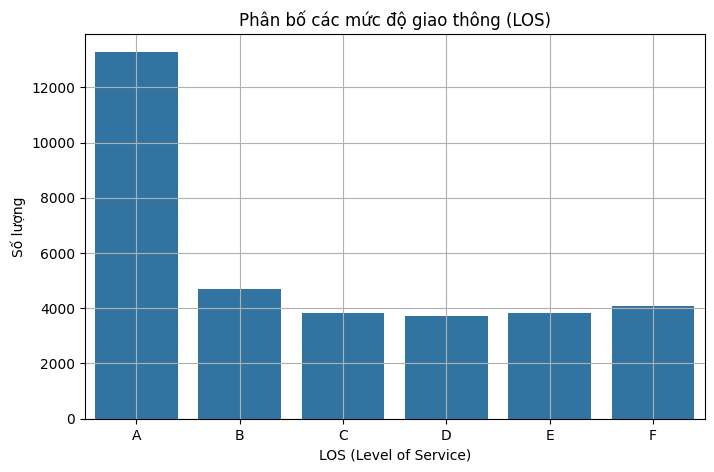

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='LOS', data=df, order=sorted(df['LOS'].unique()))
plt.title("Phân bố các mức độ giao thông (LOS)")
plt.xlabel("LOS (Level of Service)")
plt.ylabel("Số lượng")
plt.grid(True)
plt.show()


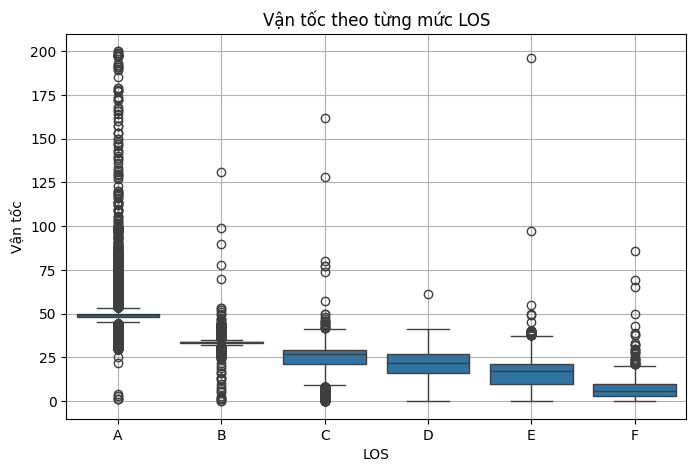

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='LOS', y='velocity', data=df, order=sorted(df['LOS'].unique()))
plt.title("Vận tốc theo từng mức LOS")
plt.xlabel("LOS")
plt.ylabel("Vận tốc")
plt.grid(True)
plt.show()


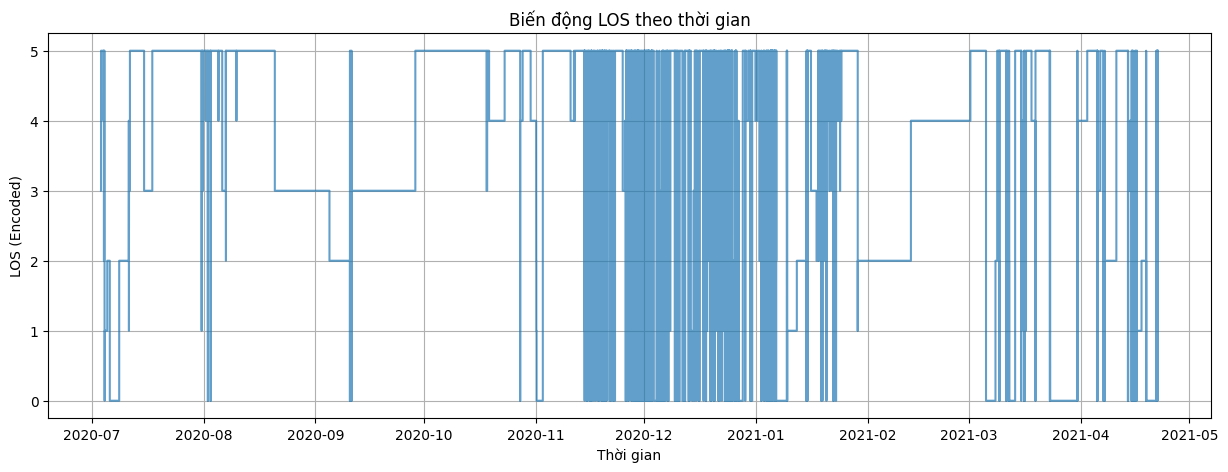

In [21]:
plt.figure(figsize=(15, 5))
plt.step(df['date'], df['LOS_encoded'], where='mid', alpha=0.7)
plt.title("Biến động LOS theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("LOS (Encoded)")
plt.grid(True)
plt.show()


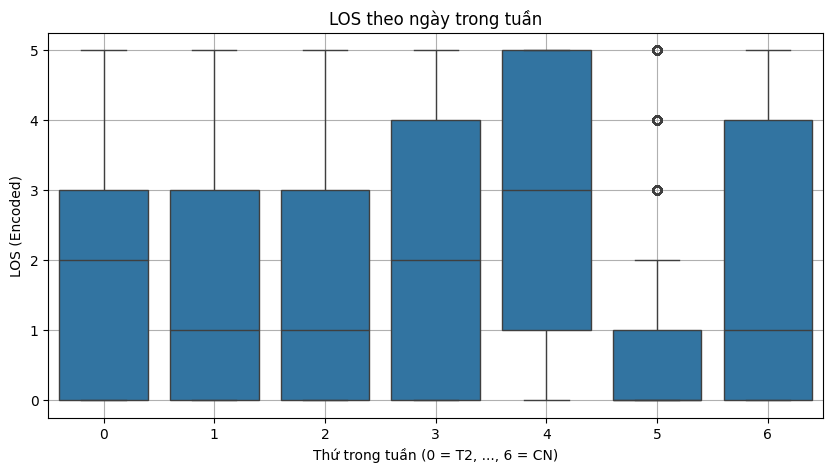

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='LOS_encoded', data=df)
plt.title("LOS theo ngày trong tuần")
plt.xlabel("Thứ trong tuần (0 = T2, ..., 6 = CN)")
plt.ylabel("LOS (Encoded)")
plt.grid(True)
plt.show()


### 3. Huấn luyện mô hình

In [23]:
from neupy import algorithms
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Encode y thành one-hot
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_oh = one_hot_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_oh = one_hot_encoder.transform(y_test.values.reshape(-1, 1))

# Tinh chỉnh sigma
sigma_values = np.logspace(-2, 1, 10)  # Thử các giá trị từ 0.01 đến 10
best_score = 0
best_sigma = None
for sigma in sigma_values:
    grnn = algorithms.GRNN(std=sigma, verbose=False)
    grnn.fit(X_train, y_train_oh)
    y_pred_proba = grnn.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    score = accuracy_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_sigma = sigma

print(f"Best sigma: {best_sigma}, Best accuracy: {best_score:.4f}")

# Huấn luyện lại với sigma tốt nhất
grnn = algorithms.GRNN(std=best_sigma, verbose=True)
grnn.fit(X_train, y_train_oh)
y_pred_proba = grnn.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Đánh giá mô hình
print("\nFinal Classification Report with Best Sigma:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

ImportError: cannot import name 'MutableMapping' from 'collections' (C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\collections\__init__.py)

In [ ]:
import theano
import neupy
print(theano.__version__)  # Nên in ra 1.0.5
print(neupy.__version__)   # Nên in ra 0.8.2

ImportError: cannot import name 'MutableMapping' from 'collections' (C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\collections\__init__.py)